# Forecasting beer sales 

### Source
- https://scikit-learn.org/stable/index.html
- https://www.mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/
- https://alkaline-ml.com/pmdarima/quickstart.html
- https://facebook.github.io/prophet/


- https://catboost.ai/docs/concepts/python-reference_catboostregressor.html


- https://www.analyticsvidhya.com/blog/2015/12/improve-machine-learning-results/
- https://www.analyticsvidhya.com/blog/2015/08/introduction-ensemble-learning/


## Install

In [1]:
# !pip install numpy
# !pip install pandas

# !pip install python-dotenv
# !pip install pyodbc

# !pip install sklearn
# !pip install joblib
# !pip install optuna

# !pip install lightgbm
# !pip install xgboost
# !pip install catboost

# !pip install matplotlib
# !pip install seaborn
# !pip install rfpimp
# !pip install skater
# !pip install eli5
# !pip install pandas-profiling
# !pip install ipywidgets

## Init

In [2]:
import pandas as pd
import numpy as np
import os
import datetime

import pyodbc
from dotenv import load_dotenv

from sklearn.experimental import enable_hist_gradient_boosting, enable_iterative_imputer
from sklearn import datasets, linear_model, ensemble, gaussian_process, isotonic, kernel_ridge, neighbors, neural_network, svm, tree
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, max_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold,train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, FunctionTransformer,  StandardScaler, LabelEncoder, LabelBinarizer, OrdinalEncoder, RobustScaler
from sklearn.inspection import permutation_importance
import joblib

import lightgbm  
import xgboost 
import catboost
# from keras.wrappers.scikit_learn import KerasRegressor
# from keras.models import Sequential
# from keras.layers import Dense
import optuna

# visualization lib
import matplotlib.pyplot as plt
import seaborn as sns
from rfpimp import permutation_importances, plot_importances, plot_corr_heatmap
# import shap
import eli5
from eli5.sklearn import PermutationImportance
# from pandas_profiling import ProfileReport

from helper import absolute_score, show_pred, show_feature_importances, reduce_mem_usage

In [3]:
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

In [4]:
load_dotenv()

True

In [5]:
DATASET_MARKET = 'off-trade'
DATASET_COUNTRY = 'all'

DATASET_NAME = f'{DATASET_MARKET}_{DATASET_COUNTRY}'

if (DATASET_MARKET == 'on-trade'):
    DATASET_FROM_YEAR = 2016
    DATASET_FROM_WEEK = 1
    DATASET_TO_YEAR = 2021
    DATASET_TO_WEEK = 24

if (DATASET_MARKET == 'off-trade'):
    DATASET_FROM_YEAR = 2016
    DATASET_FROM_WEEK = 1
    DATASET_TO_YEAR = 2021
    DATASET_TO_WEEK = 24


DATA_PATH = f'./data/{DATASET_NAME}_data.csv'

MODEL_PATH = f'./models/{DATASET_NAME}_model.joblib'
SCALER_PATH = f'./models/{DATASET_NAME}_scaler.joblib'
IMPUTER_PATH = f'./models/{DATASET_NAME}_imputer.joblib'
SKU_ENCODER_PATH = f'./models/{DATASET_NAME}_sku_encoder.joblib'
BRAND_ENCODER_PATH = f'./models/{DATASET_NAME}_brand_encoder.joblib'

RESULT_CSV_PATH = f'./train_results/{DATASET_NAME}_train_result.csv'
RESULT_EXCEL_PATH = f'./train_results/{DATASET_NAME}_train_result.xlsx'

MAX_N_JOBS = 8

TRAIN_TO_YEAR = 2021
TRAIN_TO_WEEK = 15

## Load Data

In [6]:
try:
    server = os.getenv('DB_SERVER')
    database = os.getenv('DB_DATABASE')
    username = os.getenv('DB_USERNAME')
    password = os.getenv('DB_PASSWORD')

    cnxn = pyodbc.connect(f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}') 

    country_par = 'NULL' if DATASET_COUNTRY == 'all' else DATASET_COUNTRY
    query1=f'EXEC [dbo].[ML_Table_extension_data] @Country={country_par}, @FromYear={DATASET_FROM_YEAR}, @FromWeek={DATASET_FROM_WEEK}, @ToYear={DATASET_TO_YEAR}, @ToWeek={DATASET_TO_WEEK}, @Market="{DATASET_MARKET.upper()}"'
    
    data = pd.read_sql(query1, cnxn)

    data.to_csv(DATA_PATH, index=False)
except:
    print("Unexpected error:", sys.exc_info()[0])
    data = pd.read_csv(DATA_PATH, header=0)
else:
    cnxn.close()

data = data.sort_values(by=['Year', 'Week', 'SkuShort', 'Country']).reset_index().drop(columns=['index'])    
data.head()

Unexpected error: <class 'pyodbc.OperationalError'>


,SkuShort,Brand,Country,Year,Week,NumberWorkdays,PrevNumberWorkdays,NextNumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,SalesHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,OldPredSalesHl
0,1015,PILSNER URQUELL,CZ,2016,1,5,NaN,5,-1.164286,0.935714,1.014286,False,NaN,NaN,1637.344974,1805.0000,NaN,NaN,NaN,NaN,705.4995
1,1015,PILSNER URQUELL,SK,2016,1,4,NaN,5,-1.164286,0.935714,1.014286,False,NaN,NaN,631.153086,506.9000,NaN,NaN,NaN,NaN,600.1846
2,1016,PILSNER URQUELL,CZ,2016,1,5,NaN,5,-1.164286,0.935714,1.014286,False,NaN,NaN,293.344724,159.1128,NaN,NaN,NaN,NaN,160.0957
3,1016,PILSNER URQUELL,SK,2016,1,4,NaN,5,-1.164286,0.935714,1.014286,False,NaN,NaN,40.885316,26.9280,NaN,NaN,NaN,NaN,2.8216
4,1022,PILSNER URQUELL,CZ,2016,1,5,NaN,5,-1.164286,0.935714,1.014286,False,NaN,NaN,59.144115,72.4900,NaN,NaN,NaN,NaN,74.4420


In [7]:
data = reduce_mem_usage(data, ignoreCols=['SalesHl'])

Mem. usage decreased to  3.02 Mb (64.0% reduction)


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54652 entries, 0 to 54651
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SkuShort            54652 non-null  int32  
 1   Brand               54652 non-null  object 
 2   Country             54652 non-null  object 
 3   Year                54652 non-null  int16  
 4   Week                54652 non-null  int8   
 5   NumberWorkdays      54652 non-null  int8   
 6   PrevNumberWorkdays  54512 non-null  float16
 7   NextNumberWorkdays  54652 non-null  int8   
 8   AvgTemp             54652 non-null  float16
 9   AvgRain             54652 non-null  float16
 10  AvgSun              54652 non-null  float16
 11  IsLockdown          54652 non-null  bool   
 12  PdtHl               33476 non-null  float16
 13  PrevWeekPdtHl1      33087 non-null  float16
 14  BgtHl               47073 non-null  float16
 15  SalesHl             47202 non-null  float64
 16  Prev

In [9]:
data.describe()

,SkuShort,Year,Week,NumberWorkdays,PrevNumberWorkdays,NextNumberWorkdays,AvgTemp,AvgRain,AvgSun,PdtHl,PrevWeekPdtHl1,BgtHl,SalesHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,OldPredSalesHl
count,54652.000000,54652.000000,54652.000000,54652.000000,5.451200e+04,54652.000000,5.465200e+04,5.465200e+04,5.465200e+04,3.347600e+04,3.308700e+04,47073.00000,47202.000000,4.668200e+04,4.632300e+04,3.633100e+04,2.592000e+04,4.568900e+04
mean,7139.814023,2018.425035,26.071397,4.786376,inf,4.787785,inf,inf,inf,inf,inf,inf,648.192993,inf,inf,inf,inf,inf
std,4817.412693,1.557283,15.010044,0.497913,5.034180e-01,0.497983,7.652344e+00,1.653320e+00,3.058594e+00,inf,inf,inf,1562.277626,inf,inf,inf,inf,inf
min,1015.000000,2016.000000,1.000000,2.000000,2.000000e+00,2.000000,-8.281250e+00,0.000000e+00,1.428223e-01,2.174377e-02,2.174377e-02,-28.56250,0.020000,2.000427e-02,2.000427e-02,3.500366e-02,2.000427e-02,6.210327e-02
25%,3115.000000,2017.000000,13.000000,5.000000,5.000000e+00,5.000000,4.000000e+00,4.643555e-01,2.185547e+00,2.537500e+01,2.546875e+01,38.78125,28.404000,2.906250e+01,2.920312e+01,3.346875e+01,4.356250e+01,3.628125e+01
50%,6077.000000,2019.000000,25.000000,5.000000,5.000000e+00,5.000000,1.046875e+01,1.128906e+00,4.792969e+00,1.206250e+02,1.200000e+02,156.12500,131.020000,1.327500e+02,1.326250e+02,1.486250e+02,1.685000e+02,1.490000e+02
75%,11271.000000,2020.000000,39.000000,5.000000,5.000000e+00,5.000000,1.767188e+01,2.271484e+00,7.230469e+00,4.817500e+02,4.785000e+02,567.50000,558.048750,5.630000e+02,5.620000e+02,5.855000e+02,6.340000e+02,5.955000e+02
max,41670.000000,2021.000000,53.000000,5.000000,5.000000e+00,5.000000,2.581250e+01,7.957031e+00,1.386719e+01,3.846400e+04,3.846400e+04,16008.00000,24281.500000,2.428800e+04,2.428800e+04,2.428800e+04,2.315200e+04,2.486400e+04


## Missing Values

In [10]:
data.isna().sum()

SkuShort              0    
Brand                 0    
Country               0    
Year                  0    
Week                  0    
NumberWorkdays        0    
PrevNumberWorkdays    140  
NextNumberWorkdays    0    
AvgTemp               0    
AvgRain               0    
AvgSun                0    
IsLockdown            0    
PdtHl                 21176
PrevWeekPdtHl1        21565
BgtHl                 7579 
SalesHl               7450 
PrevWeekSalesHl1      7970 
PrevWeekSalesHl2      8329 
PrevYearSalesHl1      18321
PrevYearSalesHl2      28732
OldPredSalesHl        8963 
dtype: int64

## Data Visualizations

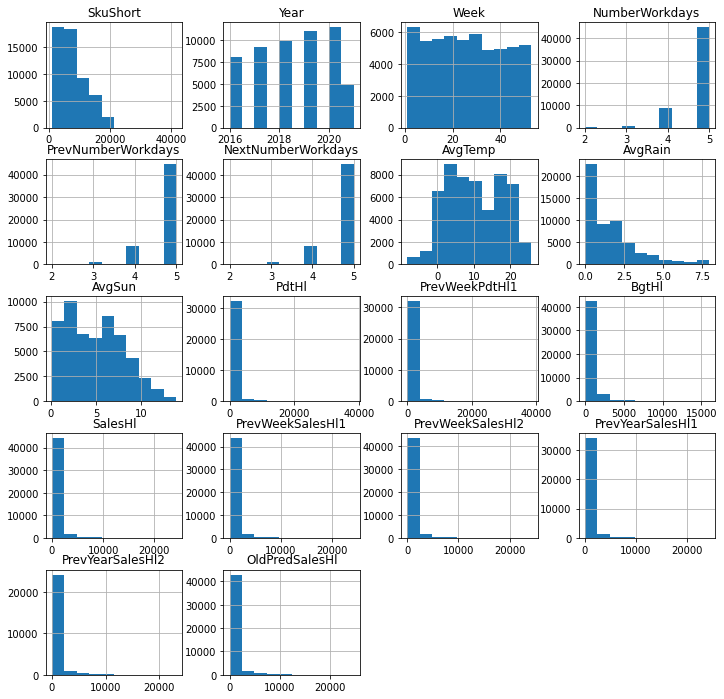

In [11]:
data.hist(figsize=[12,12])
plt.show()

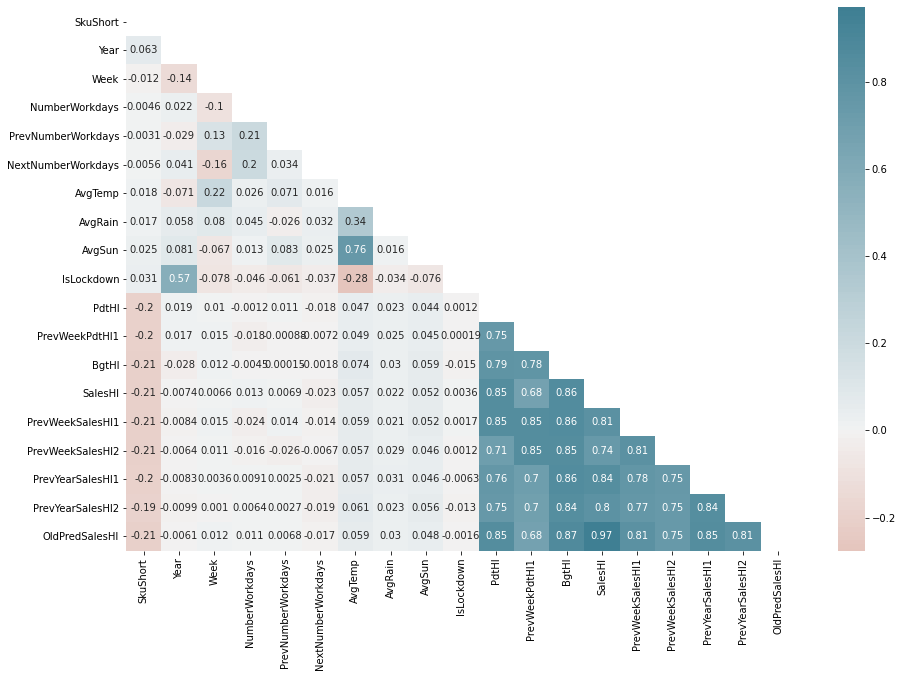

In [12]:
plt.subplots(figsize = (15,10))
mask = np.zeros_like(data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data.corr(), cmap=sns.diverging_palette(20, 220, n=200), annot=True, mask=mask, center = 0)
plt.show()

In [13]:
numData = data.select_dtypes(exclude='object')
numDatacorr = numData.corr()
salesHlFrame = numDatacorr['SalesHl'].sort_values(ascending=False).head(10).to_frame()

salesHlFrame.style.background_gradient(cmap=sns.light_palette("cyan", as_cmap=True))

,SalesHl
SalesHl,1.000000
OldPredSalesHl,0.971445
BgtHl,0.858415
PdtHl,0.847476
PrevYearSalesHl1,0.837645
PrevWeekSalesHl1,0.811917
PrevYearSalesHl2,0.803461
PrevWeekSalesHl2,0.738443
PrevWeekPdtHl1,0.678959
AvgTemp,0.056960


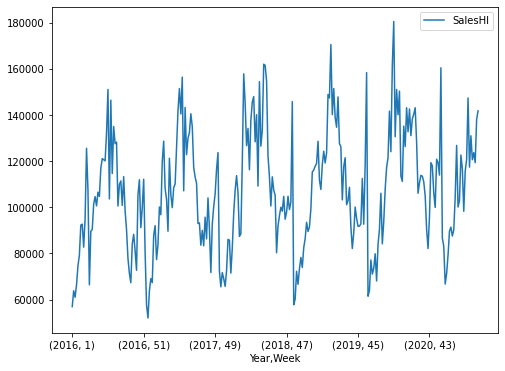

In [14]:
data.groupby(['Year','Week']).sum().plot(y=['SalesHl'], figsize=(8,6))
plt.show()

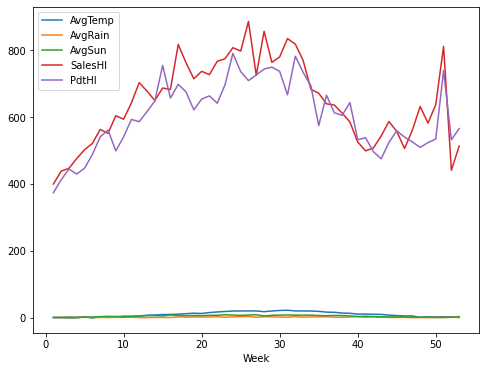

In [15]:
data.groupby(['Week']).mean().plot(y=['AvgTemp', 'AvgRain', 'AvgSun', 'SalesHl', 'PdtHl'], figsize=(8,6))
plt.show()

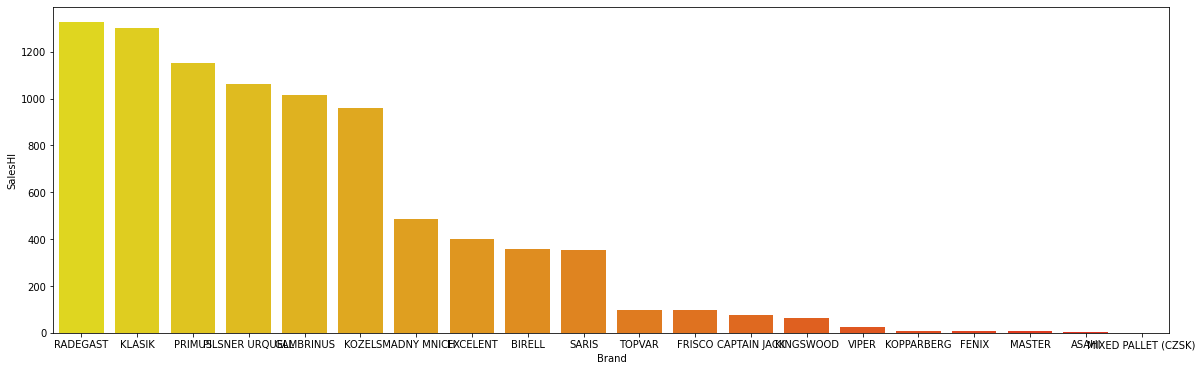

In [16]:
plt.figure(figsize=(20,6))
g_pps = data.groupby('Brand')['SalesHl'].mean().sort_values(ascending=False)
axis = sns.barplot(x=g_pps.index, y=g_pps, palette='autumn_r')
axis.set_xlabel('Brand')
axis.set_ylabel('SalesHl')

plt.show()

## Skewness and Kurtesis

In [17]:
data.skew()

SkuShort              0.789726
Year                 -0.062593
Week                  0.068405
NumberWorkdays       -2.682361
PrevNumberWorkdays   -inf     
NextNumberWorkdays   -2.703510
AvgTemp               inf     
AvgRain               inf     
AvgSun                inf     
IsLockdown            1.840740
PdtHl                 inf     
PrevWeekPdtHl1        inf     
BgtHl                 inf     
SalesHl               5.380103
PrevWeekSalesHl1      inf     
PrevWeekSalesHl2      inf     
PrevYearSalesHl1      inf     
PrevYearSalesHl2      inf     
OldPredSalesHl        inf     
dtype: float64

In [18]:
data.kurt()

SkuShort              0.581184 
Year                 -1.119692 
Week                 -1.190460 
NumberWorkdays        8.360695 
PrevNumberWorkdays   NaN       
NextNumberWorkdays    8.471019 
AvgTemp              NaN       
AvgRain              NaN       
AvgSun               NaN       
IsLockdown            1.388374 
PdtHl                NaN       
PrevWeekPdtHl1       NaN       
BgtHl                NaN       
SalesHl               38.215713
PrevWeekSalesHl1     NaN       
PrevWeekSalesHl2     NaN       
PrevYearSalesHl1     NaN       
PrevYearSalesHl2     NaN       
OldPredSalesHl       NaN       
dtype: float64

In [19]:

# profile = ProfileReport(data, minimal=True)
# profile.to_notebook_iframe()

## Spliting data in X and Y

In [20]:
cols_drop = ['SalesHl', 'OldPredSalesHl'] #'SkuShort', 'ProductGroup', 'PrimaryPack', 'Country', 'Year', 'BgtHl', 'Brand', 'SubBrand'

X = data.drop(cols_drop, axis=1)
X_raw = X.copy(deep=True)
y = data.SalesHl.fillna(0).to_numpy()
y_oldPred = data.OldPredSalesHl.fillna(0).to_numpy()

## LabelEncoder

In [21]:
Country_mapping = {"CZ": 1, "SK": 2}
# PrimaryPack_mapping = {"CAN": 1, "KEG": 2, "RB": 3, "NRB": 4, "TANK": 5, "PET": 6, "KEG ONE WAY": 7, "KEG WOODEN": 8}
# ProductGroup_mapping = {"CLEAR BEER": 1, "FLAVOURED BEER": 2, "CIDER": 3, "SOFT DRINKS": 4, "MALT BASED BEV": 5, "WHEAT BEER": 6, "FABS - Seltzer sugar base": 7, "CLEAR BEER - MIXED PALLET (CZSK)": 8}

X.Country = X.Country.map(Country_mapping)
# X.PrimaryPack = X.PrimaryPack.map(PrimaryPack_mapping)
# X.ProductGroup =  X.ProductGroup.map(ProductGroup_mapping)

sku_encoder = LabelEncoder()
X.SkuShort = sku_encoder.fit_transform(X.SkuShort)

brand_encoder = LabelEncoder()
X.Brand = brand_encoder.fit_transform(X.Brand)
# X.SubBrand = LabelEncoder().fit_transform(X.SubBrand)

X.head()

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,PrevNumberWorkdays,NextNumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2
0,0,13,1,2016,1,5,NaN,5,-1.164062,0.935547,1.014648,False,NaN,NaN,1637.00000,NaN,NaN,NaN,NaN
1,0,13,2,2016,1,4,NaN,5,-1.164062,0.935547,1.014648,False,NaN,NaN,631.00000,NaN,NaN,NaN,NaN
2,1,13,1,2016,1,5,NaN,5,-1.164062,0.935547,1.014648,False,NaN,NaN,293.25000,NaN,NaN,NaN,NaN
3,1,13,2,2016,1,4,NaN,5,-1.164062,0.935547,1.014648,False,NaN,NaN,40.87500,NaN,NaN,NaN,NaN
4,2,13,1,2016,1,5,NaN,5,-1.164062,0.935547,1.014648,False,NaN,NaN,59.15625,NaN,NaN,NaN,NaN


## Imputer

In [22]:
X.BgtHl = X.BgtHl.fillna(0)
X.PdtHl = X.PdtHl.fillna(0)
X.PrevWeekPdtHl1 = X.PrevWeekPdtHl1.fillna(0)
X.PrevNumberWorkdays = X.PrevNumberWorkdays.fillna(5)
X.NextNumberWorkdays = X.NextNumberWorkdays.fillna(5)

In [23]:
X.BgtHl = X.BgtHl.apply(lambda x : x if x > 0 else 0)

In [24]:
imputer = SimpleImputer(strategy='mean')
# imputer = SimpleImputer(strategy='constant', fill_value=0)
# imputer = IterativeImputer(random_state=0, skip_complete=True, min_value=0)
# imputer = KNNImputer()

X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
X

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,PrevNumberWorkdays,NextNumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2
0,0.0,13.0,1.0,2016.0,1.0,5.0,5.0,5.0,-1.164062,0.935547,1.014648,0.0,0.000000,0.000000,1637.000000,651.082094,651.884444,667.213767,703.472914
1,0.0,13.0,2.0,2016.0,1.0,4.0,5.0,5.0,-1.164062,0.935547,1.014648,0.0,0.000000,0.000000,631.000000,651.082094,651.884444,667.213767,703.472914
2,1.0,13.0,1.0,2016.0,1.0,5.0,5.0,5.0,-1.164062,0.935547,1.014648,0.0,0.000000,0.000000,293.250000,651.082094,651.884444,667.213767,703.472914
3,1.0,13.0,2.0,2016.0,1.0,4.0,5.0,5.0,-1.164062,0.935547,1.014648,0.0,0.000000,0.000000,40.875000,651.082094,651.884444,667.213767,703.472914
4,2.0,13.0,1.0,2016.0,1.0,5.0,5.0,5.0,-1.164062,0.935547,1.014648,0.0,0.000000,0.000000,59.156250,651.082094,651.884444,667.213767,703.472914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54647,283.0,19.0,1.0,2021.0,24.0,5.0,5.0,5.0,22.296875,0.065918,13.250000,0.0,0.000000,0.000000,0.000000,23.484375,27.359375,667.213767,703.472914
54648,285.0,17.0,2.0,2021.0,24.0,5.0,5.0,5.0,22.296875,0.065918,13.250000,0.0,60.875000,46.593750,178.625000,216.500000,55.437500,90.937500,331.000000
54649,288.0,17.0,2.0,2021.0,24.0,5.0,5.0,5.0,22.296875,0.065918,13.250000,0.0,1.320312,1.320312,1.307617,651.082094,651.884444,16.796875,66.937500
54650,291.0,17.0,2.0,2021.0,24.0,5.0,5.0,5.0,22.296875,0.065918,13.250000,0.0,34.656250,27.500000,105.437500,137.125000,16.921875,37.906250,353.750000


## Adding a New Feature

In [25]:
#Avg 
# X['AvgPrevWeekSalesHl'] = X[['PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(1)
X['AvgPrevYearSalesHl'] = X[['PrevYearSalesHl1', 'PrevYearSalesHl2']].mean(axis=1).round(1)
X['AvgPrevAllSalesHl'] = X[['PrevYearSalesHl1', 'PrevYearSalesHl2', 'PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(1)


X = X.drop(['PrevWeekSalesHl1', 'PrevWeekSalesHl2'], axis=1)

X

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,PrevNumberWorkdays,NextNumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevYearSalesHl1,PrevYearSalesHl2,AvgPrevYearSalesHl,AvgPrevAllSalesHl
0,0.0,13.0,1.0,2016.0,1.0,5.0,5.0,5.0,-1.164062,0.935547,1.014648,0.0,0.000000,0.000000,1637.000000,667.213767,703.472914,685.3,668.4
1,0.0,13.0,2.0,2016.0,1.0,4.0,5.0,5.0,-1.164062,0.935547,1.014648,0.0,0.000000,0.000000,631.000000,667.213767,703.472914,685.3,668.4
2,1.0,13.0,1.0,2016.0,1.0,5.0,5.0,5.0,-1.164062,0.935547,1.014648,0.0,0.000000,0.000000,293.250000,667.213767,703.472914,685.3,668.4
3,1.0,13.0,2.0,2016.0,1.0,4.0,5.0,5.0,-1.164062,0.935547,1.014648,0.0,0.000000,0.000000,40.875000,667.213767,703.472914,685.3,668.4
4,2.0,13.0,1.0,2016.0,1.0,5.0,5.0,5.0,-1.164062,0.935547,1.014648,0.0,0.000000,0.000000,59.156250,667.213767,703.472914,685.3,668.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54647,283.0,19.0,1.0,2021.0,24.0,5.0,5.0,5.0,22.296875,0.065918,13.250000,0.0,0.000000,0.000000,0.000000,667.213767,703.472914,685.3,355.4
54648,285.0,17.0,2.0,2021.0,24.0,5.0,5.0,5.0,22.296875,0.065918,13.250000,0.0,60.875000,46.593750,178.625000,90.937500,331.000000,211.0,173.5
54649,288.0,17.0,2.0,2021.0,24.0,5.0,5.0,5.0,22.296875,0.065918,13.250000,0.0,1.320312,1.320312,1.307617,16.796875,66.937500,41.9,346.7
54650,291.0,17.0,2.0,2021.0,24.0,5.0,5.0,5.0,22.296875,0.065918,13.250000,0.0,34.656250,27.500000,105.437500,37.906250,353.750000,195.8,136.4


## Split train and test

In [26]:
train_index = len(X[(X.Year <= TRAIN_TO_YEAR-1) | ((X.Year == TRAIN_TO_YEAR) & (X.Week < TRAIN_TO_WEEK))])
# train_index = len(X[(X.Year <= 2019) | ((X.Year == 2020) & (X.Week < 45))])

# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 21)
 
X_train = X.iloc[:train_index]
y_train = y[:train_index]

X_test = X.iloc[train_index:]
X_test_raw = X_raw.iloc[train_index:]
y_test = y[train_index:]
y_test_oldPred = y_oldPred[train_index:]

## Scaler

In [27]:
# scaler = MinMaxScaler()
# scaler = MaxAbsScaler()
scaler = StandardScaler() 
# scaler = RobustScaler()

scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
X_train

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,PrevNumberWorkdays,NextNumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevYearSalesHl1,PrevYearSalesHl2,AvgPrevYearSalesHl,AvgPrevAllSalesHl
0,-1.637458,0.860730,-0.826255,-1.549257,-1.662408,0.439325,0.432558,0.436344,-1.481516,-0.435334,-1.280601,-0.409662,-0.295589,-0.292932,0.865712,0.004747,0.002566,0.004005,0.002672
1,-1.637458,0.860730,1.210280,-1.549257,-1.662408,-1.536864,0.432558,0.436344,-1.481516,-0.435334,-1.280601,-0.409662,-0.295589,-0.292932,0.079550,0.004747,0.002566,0.004005,0.002672
2,-1.625366,0.860730,-0.826255,-1.549257,-1.662408,0.439325,0.432558,0.436344,-1.481516,-0.435334,-1.280601,-0.409662,-0.295589,-0.292932,-0.184393,0.004747,0.002566,0.004005,0.002672
3,-1.625366,0.860730,1.210280,-1.549257,-1.662408,-1.536864,0.432558,0.436344,-1.481516,-0.435334,-1.280601,-0.409662,-0.295589,-0.292932,-0.381617,0.004747,0.002566,0.004005,0.002672
4,-1.613275,0.860730,-0.826255,-1.549257,-1.662408,0.439325,0.432558,0.436344,-1.481516,-0.435334,-1.280601,-0.409662,-0.295589,-0.292932,-0.367331,0.004747,0.002566,0.004005,0.002672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52512,1.820693,1.587121,1.210280,1.789150,-0.809477,-1.536864,-1.532380,0.436344,-0.710955,-0.541530,0.324814,2.441036,0.216085,-0.292932,-0.218582,0.004747,0.002566,0.004005,-0.005448
52513,1.844876,1.587121,1.210280,1.789150,-0.809477,-1.536864,-1.532380,0.436344,-0.710955,-0.541530,0.324814,2.441036,-0.294520,-0.291818,-0.411225,-0.505839,-0.601550,-0.594195,-0.286156
52514,1.856967,1.587121,1.210280,1.789150,-0.809477,-1.536864,-1.532380,0.436344,-0.710955,-0.541530,0.324814,2.441036,-0.086912,-0.292932,-0.413560,0.004747,0.002566,0.004005,-0.084204
52515,1.881150,1.587121,1.210280,1.789150,-0.809477,-1.536864,-1.532380,0.436344,-0.710955,-0.541530,0.324814,2.441036,-0.294395,-0.291246,-0.348063,-0.474934,-0.555658,-0.553242,-0.539273


## Regressors

In [28]:
# model = ensemble.AdaBoostRegressor()
# model = tree.DecisionTreeRegressor(random_state=0)
#model = ensemble.BaggingRegressor(base_estimator=svm.SVR(), bootstrap=True, bootstrap_features=False, n_estimators=200, oob_score=False, warm_start=True)
#model = ensemble.ExtraTreesRegressor(n_jobs=3)
# model = ensemble.GradientBoostingRegressor()
#model = ensemble.RandomForestRegressor(n_estimators=1000, n_jobs=3, bootstrap=True, criterion='mse', oob_score=True)
#NOT model = ensemble.StackingRegressor(estimators=[('lgbm', lgb.LGBMRegressor()),('hgb', ensemble.HistGradientBoostingRegressor())],final_estimator=ensemble.BaggingRegressor(), n_jobs=4, passthrough=False) 
#model = ensemble.VotingRegressor([('lgbm', lgb.LGBMRegressor(n_estimators=5000, learning_rate=0.005)), ('rf', ensemble.RandomForestRegressor(n_estimators=1000))])
#model = ensemble.HistGradientBoostingRegressor(random_state=1, loss='least_squares', learning_rate=0.05, max_iter=350, max_leaf_nodes=70, early_stopping=False)

#NOT model = gaussian_process.GaussianProcessRegressor()
#NOT model = isotonic.IsotonicRegression()

#NOT model = kernel_ridge.KernelRidge(alpha=1.0)

#model = linear_model.LogisticRegression(max_iter=10)
# model = linear_model.LinearRegression(copy_X=True, fit_intercept=True, normalize=False, positive=False)
# model = linear_model.Ridge(max_iter=1000, copy_X=True, fit_intercept=True, normalize=True, solver='sparse_cg')
# model = linear_model.SGDRegressor(max_iter=1500, early_stopping=False, alpha=0.0001, average=True, epsilon=0.1,eta0=0.01, fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling', loss='huber', penalty='l2', power_t=0.1, shuffle=True, warm_start=True)

# model = linear_model.ElasticNet(max_iter=2000, alpha=0.001, copy_X=False, fit_intercept=True, l1_ratio=1, normalize=True, positive=False, precompute=False, selection='random', warm_start=True)
# model = linear_model.Lars(n_nonzero_coefs=1000) 
# model = linear_model.LassoLars(max_iter=500) 
# model = linear_model.OrthogonalMatchingPursuit()
# model = linear_model.ARDRegression(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=False) 
# model = linear_model.BayesianRidge(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=True) 

# model = linear_model.HuberRegressor(max_iter=500, epsilon=1.6, fit_intercept=True, warm_start=True) 
# model = linear_model.RANSACRegressor(max_trials=500)
# model = linear_model.TheilSenRegressor(max_iter=500, n_jobs=-1)

#NOT model = linear_model.PoissonRegressor(max_iter=500)
# model = linear_model.TweedieRegressor(max_iter=500, alpha=0.05, fit_intercept=False, link='auto', power=0, warm_start=True) 
#NOT model = linear_model.GammaRegressor(max_iter=500) 
#NOT model = linear_model.PassiveAggressiveRegressor(random_state=0, fit_intercept=True) 

# model = neighbors.KNeighborsRegressor(n_neighbors=7, weights='uniform', leaf_size=30, n_jobs=-1) 
# model = neighbors.RadiusNeighborsRegressor(radius=5.0, weights='distance')

#NOT model = svm.LinearSVR()

#model = xgboost.XGBRegressor(random_state=0, tree_method='approx', booster='dart', colsample_bytree= 0.5, gamma=0.0, learning_rate=0.2, max_depth=3, reg_lambda=20, min_child_weight=2, n_jobs=MAX_N_JOBS)#0.81 #reg_lambda=20,

## Find best params

In [29]:
# model = xgboost.XGBRegressor(random_state=0, tree_method='approx', booster='dart', importance_type='gain',  reg_lambda=10, reg_alpha=23, colsample_bytree= 0.5, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=100,n_jobs=MAX_N_JOBS) #0.6967554482801138

# model = ensemble.RandomForestRegressor(random_state=0, criterion='mse', min_samples_split=2, min_samples_leaf=3, n_estimators=100, max_depth=None, max_features=None, bootstrap=True, oob_score=True, n_jobs=MAX_N_JOBS) #0.7286310878145617 

model = linear_model.LinearRegression(copy_X=True, fit_intercept=True, normalize=False, positive=False)

param_grid = dict() #importance_type=['gain', 'weight', 'cover','total_gain','total_cover']
clf = GridSearchCV(model, param_grid, n_jobs=2) #, random_state=0
search = clf.fit(X_train, y_train)
#print(search.cv_results_)
print(search.best_score_)
print(search.best_params_)

0.780465897467282
{}


In [30]:
dASDds

NameError: name 'dASDds' is not defined

In [169]:
# model = xgboost.XGBRegressor(random_state=0, tree_method='approx', booster='dart', importance_type='gain',  reg_lambda=10, reg_alpha=23, colsample_bytree= 0.5, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=100,n_jobs=MAX_N_JOBS)#0.9168

# # Train the model using the training sets
# model.fit(X_train, y_train)

# # Make predictions using the testing set
# y_pred = model.predict(X_test)
# y_pred[y_pred < 0] = 0
# y_pred = y_pred.round(0)

# print(DATASET_NAME)
# print('Coefficient of determination: %.4f'% r2_score(y_test, y_pred))
# print('Absolute Score: %.4f'% absolute_score(y_test, y_pred))
# print('Mean absolute error regression loss.: %.4f'% mean_absolute_error(y_test, y_pred))
# print('Maximum residual error: %.4f'% max_error(y_test, y_pred))
# print('Mean squared error regression loss: %.4f'% mean_squared_error(y_test, y_pred))

## Models

### HistGradientBoostingRegressor 

In [170]:
hgbModel = ensemble.HistGradientBoostingRegressor(random_state=0, loss='least_squares', learning_rate=0.05, max_iter=250, max_leaf_nodes=150, min_samples_leaf=25, early_stopping=False)

### MLPRegressor

In [171]:
mlpModel = neural_network.MLPRegressor(random_state=0, activation='relu', solver='adam', hidden_layer_sizes=100, shuffle=False, warm_start=True, max_iter=1000, early_stopping=False)

### RandomForestRegressor

In [172]:
rfModel = ensemble.RandomForestRegressor(random_state=0, criterion='mse', min_samples_split=2, min_samples_leaf=3, n_estimators=100, max_depth=None, max_features=None, bootstrap=True, oob_score=True, n_jobs=MAX_N_JOBS)

### XGBRegressor

In [173]:
xgbModel = xgboost.XGBRegressor(random_state=0, tree_method='approx', booster='dart', importance_type='gain',  reg_lambda=10, reg_alpha=23, colsample_bytree= 0.5, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=100,n_jobs=MAX_N_JOBS)

### CatBoostRegressor

In [174]:
cbModel = catboost.CatBoostRegressor(learning_rate=0.05, eval_metric='RMSE', loss_function='RMSE', bootstrap_type='No', leaf_estimation_method='Newton', random_seed=42, verbose=0)

### LGBMRegressor

In [175]:
lgbmModel = lightgbm.LGBMRegressor(random_state=0, boosting_type='goss', learning_rate=0.2, num_leaves=35, n_estimators=50, n_jobs=MAX_N_JOBS)

### ExtraTreesRegressor

In [176]:
etrModel = ensemble.ExtraTreesRegressor(bootstrap=True, criterion='mse', max_features='auto', oob_score=True, warm_start=True, n_estimators=200, min_weight_fraction_leaf=0, min_samples_split=2 , min_samples_leaf=2, ccp_alpha=0.7)

### Use models

In [177]:
regression_models = [lgbmModel, cbModel, hgbModel, rfModel, etrModel]

if (DATASET_MARKET == 'on-trade'):
    regression_models = [hgbModel, lgbmModel, cbModel, rfModel, etrModel]

if (DATASET_MARKET == 'off-trade'):
    regression_models = [rfModel, etrModel, hgbModel, cbModel, lgbmModel]


regression_models

[LGBMRegressor(boosting_type='goss', learning_rate=0.2, n_estimators=50,
               n_jobs=8, num_leaves=35, random_state=0),
 HistGradientBoostingRegressor(early_stopping=False, learning_rate=0.05,
                               max_iter=250, max_leaf_nodes=150,
                               min_samples_leaf=25, random_state=0),
 RandomForestRegressor(max_features=None, min_samples_leaf=3, n_jobs=8,
                       oob_score=True, random_state=0),
 ExtraTreesRegressor(bootstrap=True, ccp_alpha=0.7, min_samples_leaf=2,
                     min_weight_fraction_leaf=0, n_estimators=200,
                     oob_score=True, warm_start=True),
 XGBRegressor(base_score=None, booster='dart', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.5, gamma=0.0,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.2, max_delta_step=None, max_depth=3,
              min_child_weight=2, missing=nan, monot

In [178]:
%%time

estimators = []
result_models = pd.DataFrame(columns=['Model', 'Score', "AbsoluteScore", 'ME', 'MSE', 'MAE'])

for reg_model in regression_models:
    
    reg_model.fit(X_train, y_train)
    y_pred = reg_model.predict(X_test)
    
    model_name = type(reg_model).__name__
    score = r2_score(y_test, y_pred)
    abs_score = absolute_score(y_test, y_pred)
    me = max_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    result_models.loc[len(result_models.index)] = [model_name, score, abs_score, me, mse, mae]

    estimators.append((model_name, reg_model))

Wall time: 3min 16s


In [179]:
col_metric = 'MAE'
min_metric = result_models[col_metric].min()
max_metric = result_models[col_metric].max()
min_weight = max_metric - ((min_metric - max_metric) * 0.2)

result_models["Weights"] = result_models[col_metric].map(lambda x: round((x - min_weight) / (min_metric - min_weight), 2))
result_models.sort_values(by=["Weights"], ascending=False)

,Model,Score,AbsoluteScore,ME,MSE,MAE,Weights
2,HistGradientBoostingRegressor,0.939633,0.745111,2516.991658,97709.133659,131.418079,1.00
0,LGBMRegressor,0.938084,0.725577,3032.155990,100215.230260,141.489572,0.88
1,CatBoostRegressor,0.935732,0.726052,2654.063823,104022.533506,141.244726,0.88
3,RandomForestRegressor,0.922539,0.720261,3735.532212,125375.568504,144.230313,0.84
4,ExtraTreesRegressor,0.923383,0.713203,3281.469469,124010.850001,147.869230,0.80
5,XGBRegressor,0.911771,0.657143,2924.428711,142804.403407,176.773235,0.45
6,MLPRegressor,0.888511,0.612053,3937.262552,180452.774055,200.021036,0.17


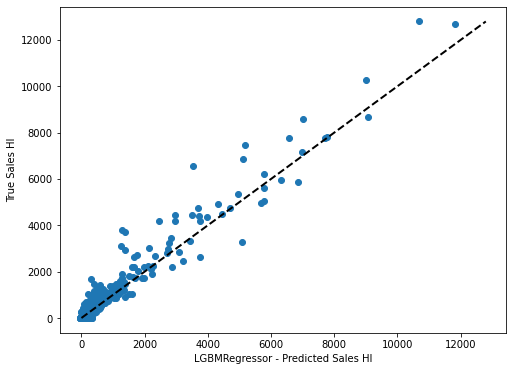

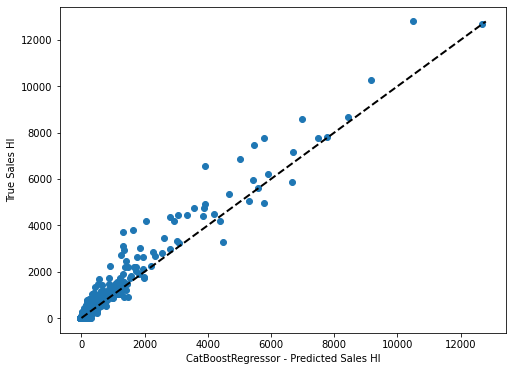

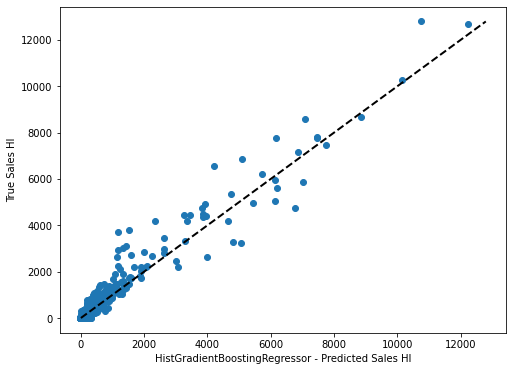

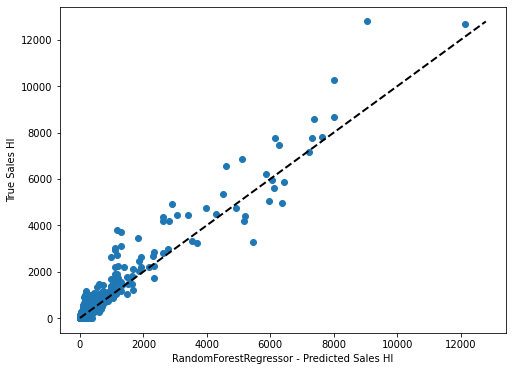

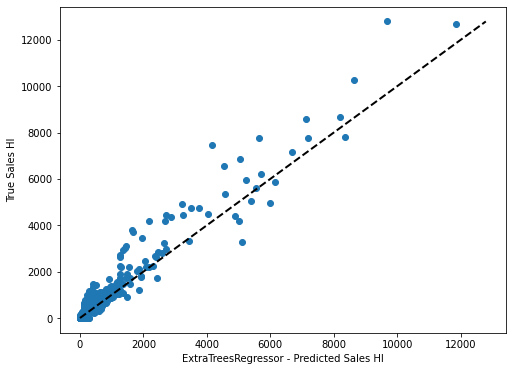

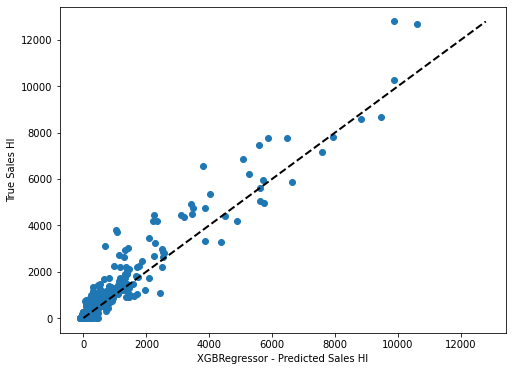

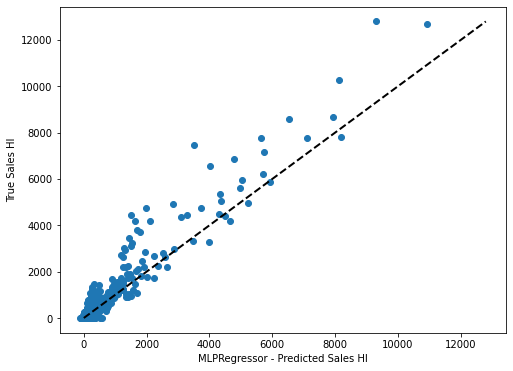

In [180]:
for key, model in estimators:
    y_pred = model.predict(X_test)
    show_pred(y_test, y_pred, f"{key} - Predicted Sales Hl", "True Sales Hl")

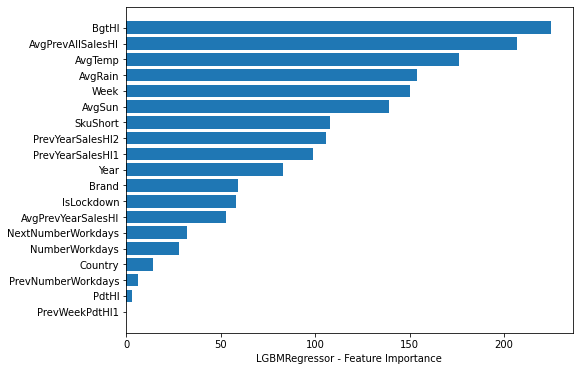

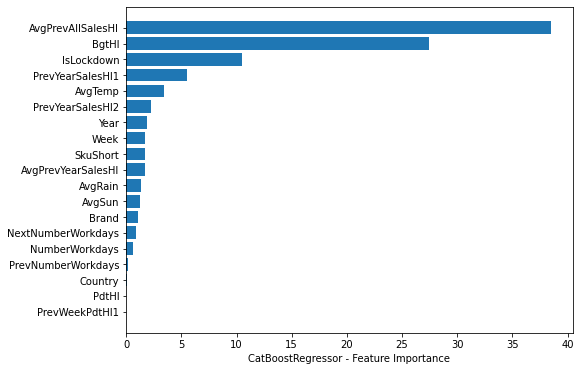

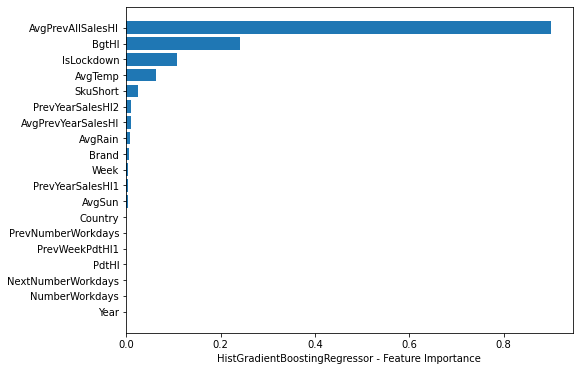

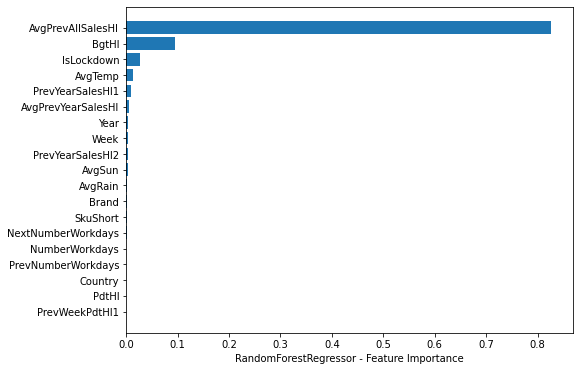

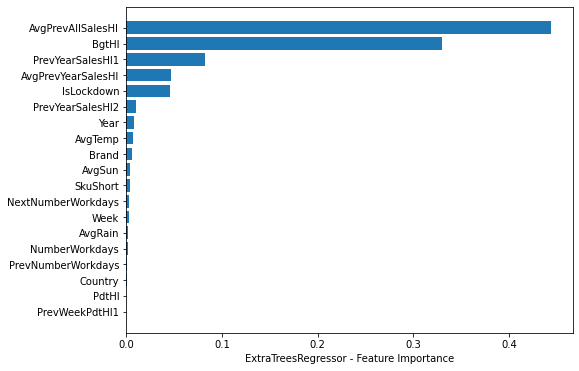

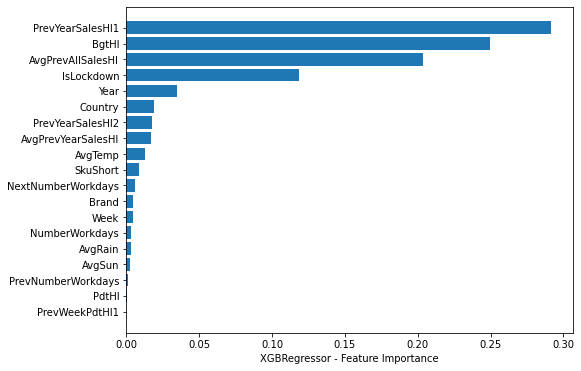

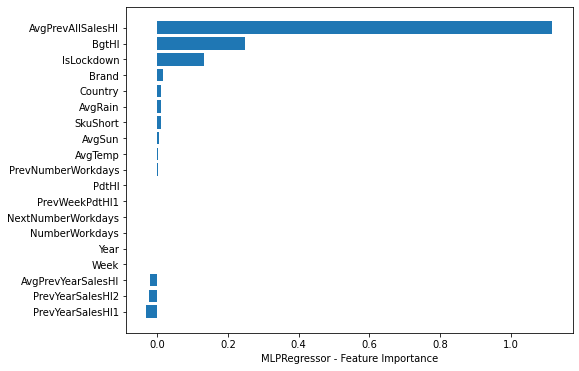

In [181]:
for key, model in estimators:
    show_feature_importances(model, X_test, y_test)

### VotingRegressor

In [182]:
%%time

model = ensemble.VotingRegressor(estimators=estimators, weights=result_models.Weights.values, n_jobs=1)

model.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = model.predict(X_test)
y_pred[y_pred < 0] = 0
y_pred = y_pred.round(0)

Wall time: 3min 18s


In [183]:
print(DATASET_NAME)
print('----------------')
print('Coefficient of determination: %.4f'% r2_score(y_test, y_pred))
print('Absolute Score: %.4f'% absolute_score(y_test, y_pred))
print('Mean absolute error regression loss.: %.4f'% mean_absolute_error(y_test, y_pred))
print('Maximum residual error: %.4f'% max_error(y_test, y_pred))
print('Mean squared error regression loss: %.4f'% mean_squared_error(y_test, y_pred))

print('----------------')

print('Classic Coefficient of determination: %.4f'% r2_score(y_test, y_test_oldPred))
print('Classic Absolute Score: %.4f'% absolute_score(y_test, y_test_oldPred))
print('Classic Mean absolute error regression loss.: %.4f'% mean_absolute_error(y_test, y_test_oldPred))
print('Classic Maximum residual error: %.4f'% max_error(y_test, y_test_oldPred))
print('Classic Mean squared error regression loss: %.4f'% mean_squared_error(y_test, y_test_oldPred))


on-trade_all
----------------
Coefficient of determination: 0.9379
Absolute Score: 0.7389
Mean absolute error regression loss.: 134.6229
Maximum residual error: 2651.5000
Mean squared error regression loss: 100458.0832
----------------
Classic Coefficient of determination: 0.9432
Classic Absolute Score: 0.7722
Classic Mean absolute error regression loss.: 117.4669
Classic Maximum residual error: 3395.5000
Classic Mean squared error regression loss: 91932.6711


In [184]:
# off-trade_all
# ----------------
# Coefficient of determination: 0.8648
# Absolute Score: 0.6197
# Mean absolute error regression loss.: 227.2489
# Maximum residual error: 5599.5000
# Mean squared error regression loss: 303284.1693

# off-trade_all
# ----------------
# Coefficient of determination: 0.8512
# Absolute Score: 0.6116
# Mean absolute error regression loss.: 232.1321
# Maximum residual error: 6050.9000
# Mean squared error regression loss: 333843.1730

# on-trade_all
# ----------------
# Coefficient of determination: 0.9428
# Absolute Score: 0.7496
# Mean absolute error regression loss.: 129.1253
# Maximum residual error: 2506.0000
# Mean squared error regression loss: 92517.5312

# on-trade
# ----------------
# Coefficient of determination: 0.9582
# Absolute Score: 0.8139
# Mean absolute error regression loss.: 95.9693
# Maximum residual error: 2890.5000
# Mean squared error regression loss: 67592.0822


# off-trade
# ----------------
# Coefficient of determination: 0.8583
# Absolute Score: 0.6249
# Mean absolute error regression loss.: 224.1787
# Maximum residual error: 6374.9000
# Mean squared error regression loss: 317901.6107


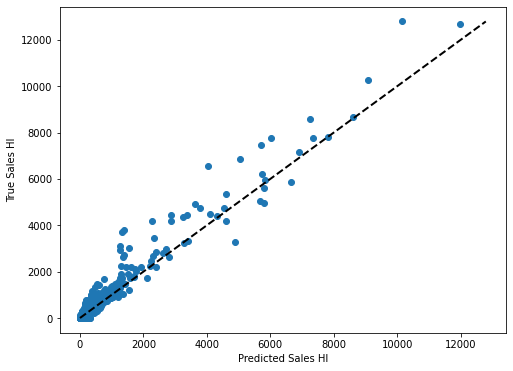

In [185]:
show_pred(y_test, y_pred, "Predicted Sales Hl", "True Sales Hl")

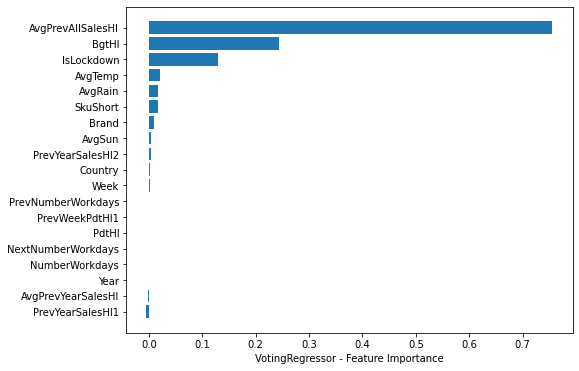

Wall time: 11.6 s


In [186]:
%%time

show_feature_importances(model, X_test, y_test)

## Save Result

In [187]:
result = X_test_raw.copy(deep=True)
result["TrueSalesHl"] = y_test
result["PredSalesHl_Classic"] = y_test_oldPred
result["PredSalesHl_ML"] = y_pred

dir_path = os.path.dirname(RESULT_CSV_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)
 
result.to_csv(RESULT_CSV_PATH, index=False)
result.to_excel(RESULT_EXCEL_PATH, index=False)

## Save model

In [188]:
dir_path = os.path.dirname(MODEL_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)

joblib.dump(model, MODEL_PATH)
joblib.dump(scaler, SCALER_PATH)
joblib.dump(imputer, IMPUTER_PATH)
joblib.dump(sku_encoder, SKU_ENCODER_PATH)
joblib.dump(brand_encoder, BRAND_ENCODER_PATH)

['./models/on-trade_all_brand_encoder.joblib']